<a href="https://colab.research.google.com/github/viratsagar/sentimentAnalysisAirline/blob/master/SentimentAnalysis_Virat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
# necessary imports
import pandas as pd
import en_core_web_sm
import re
import string
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##**Data Load**

In [183]:
tweets=pd.read_csv('Usecase3_Dataset.csv') #lodaing the data

In [184]:
tweets.head() # checking how does the data look

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


##**Data Exploration**

In [185]:
# seeing the count for individual sentiments
temp = tweets[['airline_sentiment','text']].groupby('airline_sentiment').count().sort_values(by='text',ascending=False)
temp

,text
airline_sentiment,
negative,9178
neutral,3099
positive,2363


We can see that comparatively the negative tweets are more for the airlines.

In [186]:
# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

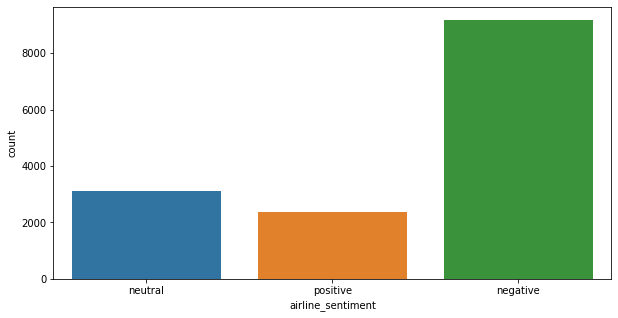

In [188]:
# visualization
# Sentiment-wise tweets
plt.figure(figsize=(10,5))
sns.countplot(x='airline_sentiment',data=tweets)

In [189]:
# Total number of tweets: airline-wise
tweets[['airline','text']].groupby(['airline']).count()

,text
airline,
American,2759
Delta,2222
Southwest,2420
US Airways,2913
United,3822
Virgin America,504


In [190]:
# Total number of tweets: airline-wise and sentiment-wise
airline_wise_sentiment=tweets.groupby(['airline','airline_sentiment']).count()
airline_wise_sentiment

text
airline        airline_sentiment      
American       negative           1960
               neutral             463
               positive            336
Delta          negative            955
               neutral             723
               positive            544
Southwest      negative           1186
               neutral             664
               positive            570
US Airways     negative           2263
               neutral             381
               positive            269
United         negative           2633
               neutral             697
               positive            492
Virgin America negative            181
               neutral             171
               positive            152

In [191]:
# percentage of different sentiments for individual airlines
pcts = airline_wise_sentiment.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
pcts

text
airline        airline_sentiment           
American       negative           71.040232
               neutral            16.781443
               positive           12.178325
Delta          negative           42.979298
               neutral            32.538254
               positive           24.482448
Southwest      negative           49.008264
               neutral            27.438017
               positive           23.553719
US Airways     negative           77.686234
               neutral            13.079300
               positive            9.234466
United         negative           68.890633
               neutral            18.236525
               positive           12.872841
Virgin America negative           35.912698
               neutral            33.928571
               positive           30.158730

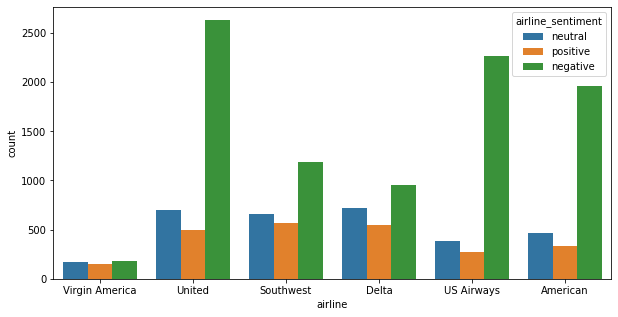

In [192]:
plt.figure(figsize=(10,5))
sns.countplot(x='airline',data=tweets,hue='airline_sentiment')

We can see that for the airlines- united, US Airways and American, comparatively more number of negative tweets are there.

In [193]:
# finding out the length of tweets
tweets["tweet_length"]= tweets["text"].str.len()
tweets.head()

,airline_sentiment,airline,text,tweet_length
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,35
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,72
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,71
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,126
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,55


In [194]:
# Average lengths of tweets sentiment-wise
tweets.groupby('airline_sentiment').mean()

,tweet_length
airline_sentiment,
negative,113.947919
neutral,87.359471
positive,86.082945


We can see that, whenever people have given negative feedbacks their tweets are longer.

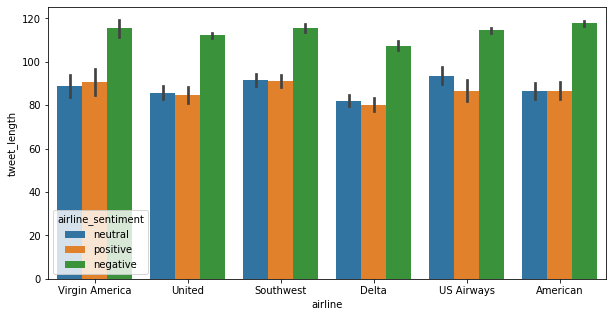

In [195]:
plt.figure(figsize=(10,5))
sns.barplot(x="airline", y='tweet_length', hue="airline_sentiment", data=tweets)

We can see that, all the airlines are almost getting similar tweet lengths for corresponding sentiments

In [196]:
# seeing the most common words in the tweets
from collections import Counter
tweets['temp_list'] = tweets['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in tweets['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp

,Common_words,count
0,to,8535
1,the,5781
2,I,5054
3,a,4359
4,for,3921
5,@united,3639
6,on,3551
7,and,3544
8,you,3232
9,my,3035


We can see above that stopwords like to, the, I etc have more occurences which are essentialy not contributing towards the sentiment. So, in the further steps, we'll remove these stopwords

In [199]:
# We can see that the airlines, tweet_length and temp_list column is not going to contribute to sentiment analysis, we'll drop it
tweets.drop(columns=['airline','temp_list','tweet_length'], inplace=True)

In [200]:
tweets.head() # cheking data after column drop

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [201]:
# we'll convert all the texts to lowercase
tweets['text']=tweets['text'].apply(lambda x: x.lower())

In [202]:
tweets.head()

,airline_sentiment,text
0,neutral,@virginamerica what @dhepburn said.
1,positive,@virginamerica plus you've added commercials t...
2,neutral,@virginamerica i didn't today... must mean i n...
3,negative,@virginamerica it's really aggressive to blast...
4,negative,@virginamerica and it's a really big bad thing...


In [203]:
tweets.isna().sum() # check for missing values

airline_sentiment    0
text                 0
dtype: int64

In [204]:
text_processor=en_core_web_sm.load() # loading the spacy english library

In [117]:
# defining a regex for handling @ and http in the tweets as they don't contribute to sentiment
pattern = "@\S+|https?:\S+|http?:\S|[^A-Za-z]+"

In [168]:
# removing stopwords, punctuations, @ symbols etc from the data
stop_words = stopwords.words('english')
clean_text=[]
for data in tweets['text']:
  clean_data = []
  doc = text_processor(data)
  for token in doc:
    clean = re.sub(pattern, '', str(token.lemma_).lower())
    if clean not in string.punctuation:
      if clean!='pron':
        lexeme = text_processor.vocab[clean]
        if lexeme.is_stop == False:
          clean_data.append(clean)
  clean_text.append(clean_data)

In [169]:
# adding an extra column for the cleaned texts
tweets['clean']=clean_text

In [170]:
tweets['clean'].head(1)

0    []
Name: clean, dtype: object

In [171]:
# we can see above that there are some empty lists above, we'd remove such rows as they don't have texts
tweets=tweets[tweets['clean'].map(lambda d: len(d)) > 0]

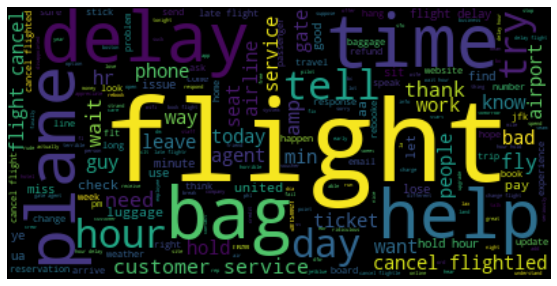

In [172]:
text=tweets[tweets['airline_sentiment']=='negative']['clean']
text=text.to_string()
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

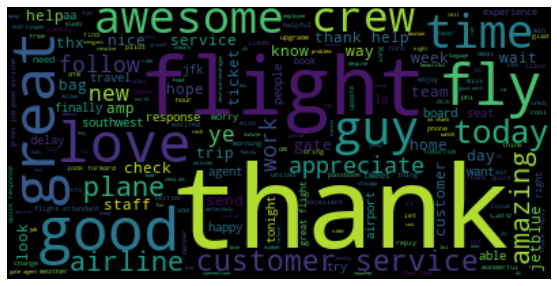

In [173]:
text=tweets[tweets['airline_sentiment']=='positive']['clean']
text=text.to_string()
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off")
plt.show()

We can see that words like cancel, customer service, time, help, delay etc. are occuring more for negative tweets whereas words like good, thank,amazing, time, love etc are prominent for positive sentiments. 

In [29]:
# Keras related imports for model training
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [30]:
# converting the text values to numerical representation
max_features = 200
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(tweets['clean'].values)
X = tokenizer.texts_to_sequences(tweets['clean'].values)
X = pad_sequences(X)

In [31]:
X

array([[   0,    0,    0, ...,  153,  899,   76],
       [   0,    0,    0, ...,  188,   16,   79],
       [   0,    0,    0, ...,    1,  295, 1945],
       ...,
       [   0,    0,    0, ...,  284,  269,   22],
       [   0,    0,    0, ...,  753,    1, 1690],
       [   0,    0,    0, ...,  365,   59,    2]], dtype=int32)

In [33]:
# creating the LSTM architecture
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
#print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# preparing the label column data and doing a split for train and validation set
Y = pd.get_dummies(tweets['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9780, 20) (9780, 3)
(4818, 20) (4818, 3)


In [36]:
# the model training
model.fit(X_train, Y_train, epochs = 5, batch_size=32, verbose = 2)

"""The Model was trained initially for 100 epochs but it  was observed that after 25 epochs ~92% accuracy is achived
and it gets saturated around 50 epochs at ~97% accuracy."""

Epoch 1/5
 - 12s - loss: 0.0648 - accuracy: 0.9763
Epoch 2/5
 - 12s - loss: 0.0634 - accuracy: 0.9758
Epoch 3/5
 - 12s - loss: 0.0627 - accuracy: 0.9769
Epoch 4/5
 - 12s - loss: 0.0615 - accuracy: 0.9760
Epoch 5/5
 - 12s - loss: 0.0597 - accuracy: 0.9793


In [39]:
# evaluating the trained model
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 32)
print("acc: %.2f" % (acc))

score: 2.14
acc: 0.71


In [46]:
# testing the trained model with a sample text for prediction

twt = ['very sad with the airline bad service']
#vectorizing the tweet by the already fit tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as  input
twt = pad_sequences(twt, maxlen=20, dtype='int32', value=0)
#print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
print(sentiment)
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("neutral")
else:
  print("Poistive")


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 477  22
   26   6]]
[9.9999797e-01 6.2145977e-10 2.0553325e-06]
negative


In [ ]:
"""

"""